https://www.kaggle.com/c/regression-tutors-expected-math-exam-results

In this competition your task will be to predict the mean math exam result (from 0 to 100 points) for students of tutors in test.csv. You will be given two datasets: train.csv (contains all features and the target) and test.csv (only features).

Ваша задача этом соревновании - предсказать средний балл на экзамене по математике, который получают ученики репетиторов из датасета test.csv. Вам будут даны два датасета: train.csv (содержит признаки и целевую переменную) и test.csv (только признаки).

In [28]:
# You can only use these imports:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
train = pd.read_csv('Choose_tutors_regression_data/train.csv')
test = pd.read_csv('Choose_tutors_regression_data/test.csv')
train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,61
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,76
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 937.6 KB


In [4]:
test.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
0,10000,46.0,3.0,1050.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10001,43.0,3.0,1850.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10002,52.0,1.0,1550.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10003,57.0,6.0,2900.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0
4,10004,44.0,4.0,3150.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(train.drop('mean_exam_points', axis=1),
                                                                    train['mean_exam_points'], test_size=0.25)

Преобразуем DataFrame в numpay arrays

In [7]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [8]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [9]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [10]:
# И класс терминального узла (листа)
# т.е. это то место где мы останавливаем вычисления и делаем прогноз

class Leaf:
    
    def __init__(self, data, y_true):
        self.data = data              # это матрица признаков
        self.y_true = y_true         # это истинные ответы
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
#         classes = {}  # сформируем словарь "класс: количество объектов" - склько раз каждый класс встретился в листе
#         for label in self.labels:
#             if label not in classes:
#                 classes[label] = 0
#             classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        # prediction = max(classes, key=classes.get)
        prediction = np.mean(self.y_true)
        return prediction

In [11]:
def mse(array):
    mean = array.mean()
    return np.mean((array - mean)**2)

In [12]:
# Расчет прироста

def gain(left_labels, right_labels, root_mse):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    # root_gini - gini на предыдущей итерации
    # gini - gini для левой и правой подвыборок
    return root_mse - p * mse(left_labels) - (1 - p) * mse(right_labels)

In [13]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [33]:
# Нахождение наилучшего разбиения
# функция перебирает все признаки и все пороги и ищет наиболее оптимальное разбиение
# data - матрица признаков, labels - лейблы
def find_best_split(data, labels, min_samples_leaf):
    
    #  обозначим минимальное количество объектов в узле
    #min_samples_leaf = 5

    root_mse = mse(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # цикл перебора по признакам
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        # перебор по всем уникальным значениям признака
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [35]:
# Построение дерева с помощью рекурсивной функции

def build_tree(X, y, min_samples_leaf):

    gain, t, index = find_best_split(X, y, min_samples_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(X, y)

    true_X, false_X, true_y, false_y = split(X, y, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_X, true_y, min_samples_leaf)
    false_branch = build_tree(false_X, false_y, min_samples_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [31]:
def random_forest(X, y, n_trees, min_samples_leaf):
    forest = []
    bootstrap = get_bootstrap(X, y, n_trees)
    
    for b_X, b_y in bootstrap:
        forest.append(build_tree(b_X, b_y, min_samples_leaf))
        
    return forest

In [17]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [18]:
# функция формирования предсказания по выборке на одном дереве

def predict(X, tree):
    
    classes = []
    for obj in X:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [19]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [20]:
# реализуем функцию, определяющую среднеквадратичную ошибку
def mserror(y, y_pred):
    return (sum((y - y_pred)**2)) / len(y)

In [21]:
# r2
def r2(y, y_pred):
    return 1 - np.sum((y - y_pred)**2) / np.sum( (y - np.sum(y) / len(y)  )**2)

---
Построим лес из одного дерева

In [36]:
%%time
n_trees = 2
min_samples_leaf = 5

my_forest_1 = random_forest(X_train_np, y_train_np, n_trees, min_samples_leaf)

Wall time: 12.8 s


In [37]:
# Получим ответы для обучающей и тестовой  выборки 
y_train = tree_vote(my_forest_1, X_train_np)
y_test = tree_vote(my_forest_1, X_test_np)

In [38]:
# Точность на обучающей и тестовой выборке
train_mse = mserror(y_train_np, y_train)
print(f'MSE случайного леса из {n_trees} деревьев на обучающей выборке: {train_mse:.3f}')

test_mse = mserror(y_test_np, y_test)
print(f'MSE случайного леса из {n_trees} деревьев на тестовой выборке: {test_mse:.3f}')

MSE случайного леса из 2 деревьев на обучающей выборке: 66.575
MSE случайного леса из 2 деревьев на тестовой выборке: 122.298


In [39]:
train_r2 = r2(y_train_np, y_train)
print(f'R2 случайного леса из {n_trees} деревьев на обучающей выборке: {train_r2:.3f}')

test_r2 = r2(y_test_np, y_test)
print(f'R2 случайного леса из {n_trees} деревьев на тестовой выборке: {test_r2:.3f}')

R2 случайного леса из 2 деревьев на обучающей выборке: 0.690
R2 случайного леса из 2 деревьев на тестовой выборке: 0.448


In [41]:
n_trees_list = []
min_samples_leaf_list = []
train_score = []
test_score = []

for n_trees in tqdm(range(2, 21)):
    
    for min_samples_leaf in range(2, 6):
        
        my_forest_1 = random_forest(X_train_np, y_train_np, n_trees, min_samples_leaf)
        y_train = tree_vote(my_forest_1, X_train_np)
        y_test = tree_vote(my_forest_1, X_test_np)
        
        n_trees_list.append(n_trees)
        min_samples_leaf_list.append(min_samples_leaf)
        
        train_score.append(round(r2(y_train_np, y_train), 3))
        test_score.append(round(r2(y_test_np, y_test), 3))
        
print(f'Параметры количества деревьев: {n_trees_list}')
print(f'Точность алгоритма на трейне: {train_score}')
print(f'Точность алгоритма на тесте: {test_score}')
print(f'Done!')

100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [1:49:51<00:00, 346.93s/it]

Параметры количества деревьев: [2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20]
Точность алгоритма на трейне: [0.736, 0.721, 0.704, 0.7, 0.759, 0.722, 0.704, 0.694, 0.772, 0.719, 0.716, 0.695, 0.725, 0.661, 0.641, 0.636, 0.733, 0.659, 0.637, 0.623, 0.779, 0.655, 0.625, 0.626, 0.805, 0.674, 0.647, 0.632, 0.835, 0.678, 0.638, 0.613, 0.854, 0.695, 0.646, 0.618, 0.874, 0.702, 0.642, 0.611, 0.892, 0.714, 0.655, 0.628, 0.902, 0.747, 0.659, 0.628, 0.921, 0.755, 0.658, 0.643, 0.936, 0.776, 0.68, 0.645, 0.929, 0.796, 0.697, 0.642, 0.948, 0.801, 0.701, 0.656, 0.946, 0.823, 0.72, 0.66, 0.949, 0.775, 0.624, 0.555, 0.946, 0.811, 0.644, 0.587]
Точность алгоритма на тесте: [0.365, 0.374, 0.411, 0.481, 0.361, 0.39, 0.429, 0.438, 0.313, 0.372, 0.409, 0.474, 0.222, 0.281, 0.297, 0.33

In [44]:
min_samples_leaf_list

[2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5,
 2,
 3,
 4,
 5]

In [26]:
def get_score_plot(k, train_score, test_score):
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.xlim(0, k)
    plt.plot(list(range(k)), train_score, label='train score')
    plt.plot(list(range(k)), test_score, label='test score')
    plt.legend(loc='upper right')
    plt.show()

TypeError: '>' not supported between instances of 'int' and 'list'

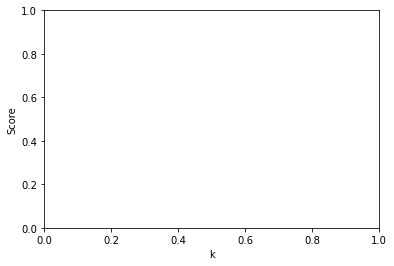

In [43]:
get_score_plot(n_trees_list, train_score, test_score)

In [45]:
%%time
n_trees = 2
min_samples_leaf = 5

my_forest_1 = random_forest(X_train_np, y_train_np, n_trees, min_samples_leaf)

Wall time: 12.9 s


In [46]:
# Получим ответы для обучающей и тестовой  выборки 
y_train = tree_vote(my_forest_1, X_train_np)
y_test = tree_vote(my_forest_1, X_test_np)

In [47]:
train_r2 = r2(y_train_np, y_train)
print(f'R2 случайного леса из {n_trees} деревьев на обучающей выборке: {train_r2:.3f}')

test_r2 = r2(y_test_np, y_test)
print(f'R2 случайного леса из {n_trees} деревьев на тестовой выборке: {test_r2:.3f}')

R2 случайного леса из 2 деревьев на обучающей выборке: 0.697
R2 случайного леса из 2 деревьев на тестовой выборке: 0.434


In [48]:
submission = pd.DataFrame({'Id': test['Id'], 'choose': y_pred_test})
submission.to_csv(f'Choose_tutors_regression_data/submission.csv', index=False, encoding='utf-8')
print('Done!')

NameError: name 'y_pred_test' is not defined